\setcounter{secnumdepth}{0}

# Assignment 3 - Stochastic Processes

    Name: Clara Periago
    Student #: s1067476

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr

In [2]:
# these are copy pasted from the last exercise
def rk4(f, dt):
    @jax.jit
    def step(x, t):
        k1 = f(t, x)
        k2 = f(t + .5 * dt, x + .5 * dt * k1)
        k3 = f(t + .5 * dt, x + .5 * dt * k2)
        k4 = f(t + dt, x + dt * k3)

        xn1 = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        return xn1

    return step

# helper wrapper that takes a step solver, initial conditions and time domain
def simulate(solver, c0, t):
    def iterate(c, t):
        xn1 = solver(c, t)
        return xn1, xn1
    
    _, xs = jax.lax.scan(iterate, c0, t)
    return xs

ERROR:2025-12-02 22:33:21,596:jax._src.xla_bridge:487: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/gup/uni/complex-adaptive-systems/.venv/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 485, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/gup/uni/complex-adaptive-systems/.venv/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/gup/uni/complex-adaptive-systems/.venv/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load the CU

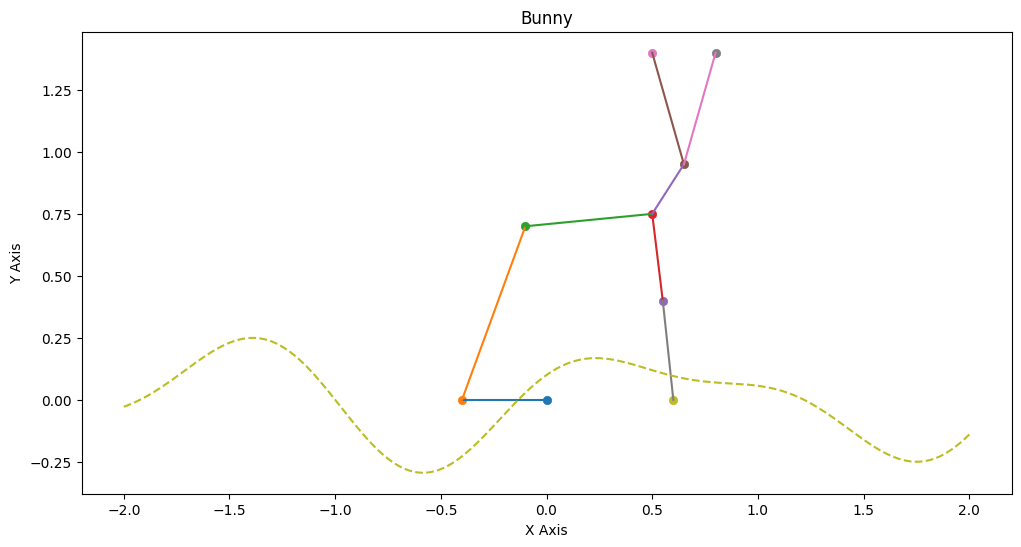

In [3]:
pos0 = jnp.array([
    [0.0, 0.0],     # 0. end of feet
    [-0.4, 0.0],    # 1. start of feet
    [-0.1, 0.7],    # 2. lower back
    [0.5, 0.75],    # 3. upper back
    [0.55, 0.4],    # 4. upper arms
    [0.65, 0.95],   # 5. head
    [0.50, 1.40],   # 6. left ear
    [0.80, 1.40],   # 7. right ear
    [0.6, 0.0],    # 8. lower arms
])

n_joints = pos0.shape[0]

i = jnp.array([0, 1, 2, 3, 3, 5, 5, 4], dtype=int)
j = jnp.array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int)
L0 = jnp.linalg.norm(pos0[i] - pos0[j], axis=1)

springs = {
    "i": i,     # index of one endpoint
    "j": j,     # index of the other endpoint
    "k": jnp.ones_like(i),                # stiffness for each spring
    "L0": L0,               # rest length for each spring
}

def draw_bunny_skel(joint_positions, springs, environment, ax):
    i = springs["i"]
    j = springs["j"]

    a_ = joint_positions[i]
    b_ = joint_positions[j]
    ab = jnp.stack((a_, b_), axis=2) # (k, xy, ij)
    # print(a_.shape, b_.shape, ab.shape)

    for x, y in ab:
        # print(a.shape)
        ax.plot(x, y)

    # 
    # ax.plot(*ab.T)
    draw_env(environment, ax)

    for k in joint_positions:
        ax.scatter(*k, lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_title("Bunny")

def draw_env(environment, ax):
    ax.plot(*environment, linestyle="--", label="floor")

xs = jnp.linspace(-2, 2, 200)
h  = 0.2 * jnp.sin(3*xs) + 0.1 * jnp.cos(5*xs)
environment = jnp.stack((xs, h), axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
draw_bunny_skel(pos0, springs, environment, ax)

$$
F_{ij}​ = − k (∣∣x_i - x_j∣∣ - L_0​) \hat{d}
$$

In [4]:
def spring_forces(x, v, springs):
    i = springs["i"]
    j = springs["j"]
    k = springs["k"]
    L0 = springs["L0"]

    # displacement vectors and lengths
    d = x[i] - x[j]                       # (M,2)
    dist = jnp.linalg.norm(d, axis=1) # (M,)
    dist = jnp.maximum(dist, 1e-8)    # avoid divide-by-zero

    # unit directions
    dir_hat = d / dist[:, None]

    # spring extension/compression amount
    stretch = dist - L0               # (M,)

    # Hooke's law force magnitude
    Fmag = -k * stretch               # (M,)

    # vector spring forces applied on i (and opposite on j)
    F = Fmag[:, None] * dir_hat       # (M,2)

    # accumulate forces using scatter_add
    N = x.shape[0]
    forces = jnp.zeros((N,2))
    # print(forces.shape)

    forces = forces.at[i].add(F)      # add force to endpoint i
    forces = forces.at[j].add(-F)     # opposite force to endpoint j

    return forces

def ground_forces(pos, environment):
    y = pos[:, 1]
    ground_y = jnp.interp(pos[:, 0], environment[0], environment[1])

    penetration = jnp.maximum(ground_y - y, 0.0)

    # upward push proportional to penetration depth
    k = 1.
    Fy = k * penetration

    return jnp.stack([jnp.zeros_like(Fy), Fy], axis=1) # 0s for x, fy for y

def bunny_dynamics(springs, masses, environment):
    def f(t, c):
        # 1. unpack state
        pos, vel = c
        # print(c.shape, pos.shape, vel.shape)
        # jax.debug.print("{p} {v}", p=pos, v=vel)

        # 2. compute spring forces
        F_spring = 0. #spring_forces(pos, vel, springs)
        # print(F_spring.shape)

        # 3. external forces (gravity, ground)
        F_grav   =  jnp.array([0., -.1])[None, :] # gravity_forces(masses)
        F_ground = ground_forces(pos, environment)

        # 4. acceleration = F / m
        acc = (F_spring + F_grav + F_ground) / masses[:, None]

        # 5. pack derivatives: dx/dt = v, dv/dt = acc
        # shape should be (P_V, K, X_Y)
        return jnp.stack((vel, acc), axis=0)

    return f

(3, 2)
(Array(0., dtype=float32), Array(-0.1, dtype=float32)) (Array(0., dtype=float32), Array(0.19987378, dtype=float32))
(Array(0.5, dtype=float32), Array(0.2, dtype=float32)) (Array(0., dtype=float32), Array(0., dtype=float32))
(Array(0.7, dtype=float32), Array(0.1, dtype=float32)) (Array(0., dtype=float32), Array(0., dtype=float32))


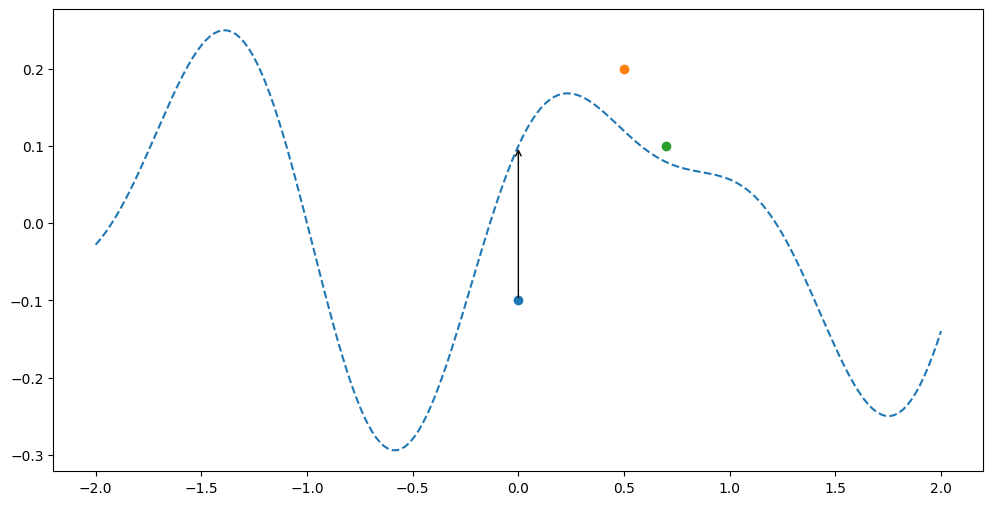

In [5]:
sample_positions = jnp.array([[0, -.1], [ .5,.2],  [.7,.1]])
print(sample_positions.shape)

dv = ground_forces(sample_positions, environment)

fig, ax = plt.subplots(figsize=(12, 6))
draw_env(environment, ax)

for i, (dx, dy) in enumerate(dv):
    x, y = sample_positions[i]
    print((x, y), (dx, dy))
    ax.scatter(x, y)
    ax.annotate("", xytext=(x, y), xy=(x+dx, y+dy),
            arrowprops=dict(arrowstyle="->"))

In [6]:
dt = 0.01
t = jnp.arange(0, 10, dt)

masses = jnp.ones((n_joints,))
lor_attr = bunny_dynamics(springs, masses, environment) # instance of our f(*x, t) system
solver = rk4(lor_attr, dt) # solver function for our system & dt
v0 = jnp.zeros_like(pos0)
s0 = jnp.stack((pos0 + .2 * jnp.ones_like(pos0), v0), axis=0)
xyzs = simulate(solver, s0, t) # iterate over the t space

In [7]:
xyzs.shape

(1000, 2, 9, 2)

In [8]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

def animate_draw(arr, draw_fn, interval=100):
    fig, ax = plt.subplots(figsize=(12, 6))

    def update(frame_idx):
        ax.clear()
        draw_fn(arr[frame_idx], springs, environment, ax)
        return ax,

    anim = FuncAnimation(fig, update, frames=len(arr), interval=interval)
    return anim

In [9]:
1e1

10.0

(1000, 9, 2)


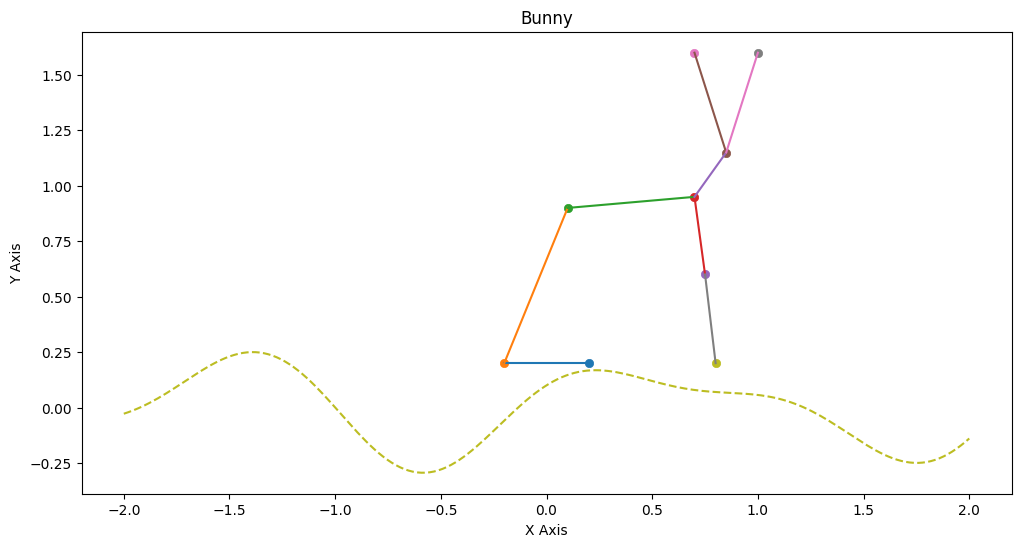

In [ ]:
joint_history = xyzs[:, 0, :, :]
print(joint_history.shape)
anim = animate_draw(joint_history, draw_bunny_skel, interval=1e3*dt)
anim.save("animation.mp4")
# HTML(anim.to_jshtml())